In [1]:
import os

In [2]:
os.chdir(r'D:\subFinder')

In [3]:
## In this script we will train supervised models
# library imports
import pandas as pd
import gensim
from Codes.Supervised_Trainer import run_end_to_end
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
import plotly.express as px

In [4]:

## read the data
# sup_data_path = r"Data/Supervised_Sequences/dbCAN-PUL_07-01-2022.xlsx"
new_path = r"D:\subFinder\Data\Supervised_Sequences\Table S1.xls"
data = pd.read_excel(new_path)
data["updated_substrate (09/01/2022)"] = data["updated_substrate (09/01/2022)"].str.strip()
data["updated_substrate (09/01/2022)"] = data["updated_substrate (09/01/2022)"].str.strip()


## removing the catch all classes
## for example multiple substrates and others 
old_data = pd.read_csv('Data/Supervised_Sequences/pul_seq_low_high_substr_year_corrected.tsv', sep = "\t")

old_data["high_level_substr"] = old_data["high_level_substr"].str.strip()

bad_puls = old_data[old_data["high_level_substr"].isin(["multiple_substrates", "mono/di/trisaccharide", "-", "human milk oligosaccharide", 
                                            "glycoprotein", "plant polysaccharide", "cellobiose"])]["PULid"].values


data = data[~data["PUL ID"].isin(bad_puls)]

data = data[["PUL ID", "updated_substrate (09/01/2022)"]]
data = pd.merge(data, old_data[["PULid","sig_gene_seq"]], left_on = ["PUL ID"], right_on = ["PULid"], how = "left")
data.columns = ["PUL ID", "high_level_substr", "PULid", "sig_gene_seq"]

data = data[~data["PUL ID"].isin(bad_puls)]


In [5]:
## read the data
# sup_data_path = r"Data/Supervised_Sequences/dbCAN-PUL_07-01-2022.xlsx"
new_sup_data_with_nulls = pd.read_csv(r"D:\subFinder\Data\Supervised_Sequences\supervised_seq_with_null.tsv", sep = "\t", 
                                      header = None)
new_sup_data_with_nulls.columns = ["PUL ID", "sequence"]

In [6]:
data = pd.merge(data, new_sup_data_with_nulls, on = ["PUL ID"], how = "left")
data = data.drop(["sig_gene_seq"],1)
data.columns = ['PUL ID', 'high_level_substr', 'PULid', 'sig_gene_seq']

C:\Users\vedpi\AppData\Local\Temp\ipykernel_6392\282975859.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop(["sig_gene_seq"],1)


In [7]:
data.to_csv(r"Data/Supervised_Sequences/updated_data_filtered.csv", index = False)

In [8]:
data["high_level_substr"].value_counts()

capsule polysaccharide synthesis      106
pectin                                 39
xylan                                  35
beta-glucan                            21
alginate                               21
host glycan                            19
cellulose                              16
starch                                 16
chitin                                 15
galactomannan                          15
glycosaminoglycan                      14
arabinan                               12
galactan                               10
alpha-mannan                            8
beta-mannan                             8
carrageenan                             8
xyloglucan                              7
fructan                                 7
arabinoxylan                            6
agarose                                 6
arabinogalactan                         5
capsule polysaccharide degradation      4
beta-galactooligosaccharide             4
glucomannan                       

In [9]:
data = data[data["high_level_substr"] != "capsule polysaccharide synthesis"]

In [10]:
data["high_level_substr"].value_counts()

pectin                                39
xylan                                 35
beta-glucan                           21
alginate                              21
host glycan                           19
cellulose                             16
starch                                16
chitin                                15
galactomannan                         15
glycosaminoglycan                     14
arabinan                              12
galactan                              10
alpha-mannan                           8
beta-mannan                            8
carrageenan                            8
xyloglucan                             7
fructan                                7
arabinoxylan                           6
agarose                                6
arabinogalactan                        5
capsule polysaccharide degradation     4
beta-galactooligosaccharide            4
glucomannan                            3
glycogen                               3
alpha-glucan    

In [12]:

# top_k = 10
K = 10
known_unknown = False


## Doc2Vec_DM model
model_dm =  gensim.models.doc2vec.Doc2Vec.load(r"Embedding_Models_10_12//doc2vec_dm") 
model_dbow = gensim.models.doc2vec.Doc2Vec.load(r"Embedding_Models_10_12//doc2vec_dbow") 
model_cbow =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models_10_12//word2vec_cbow") 
model_sg =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models_10_12//word2vec_sg") 
model_fasttext_sg =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models_10_12//fasttext_sg") 
model_fasttext_cbow =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models_10_12//fasttext_cbow") 


In [23]:
og = ["lstm_with_attention", "just_attention", "vanilla_lstm", "countvectorizer", "doc2vec_dbow", "doc2vec_dm", "word2vec_cbow", "word2vec_sg", "fasttext_sg",
                       "fasttext_cbow"]

In [14]:
og = ["lstm_with_attention", "just_attention",  "word2vec_sg"]

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

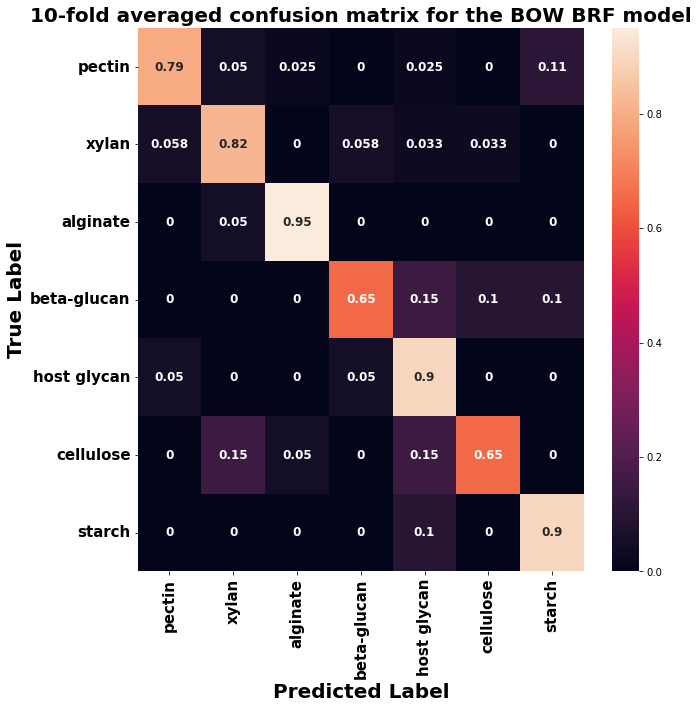

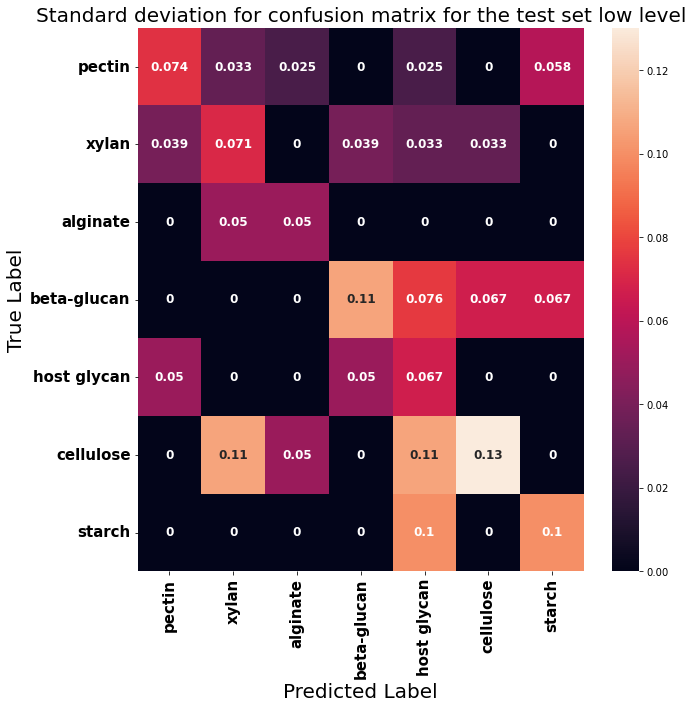

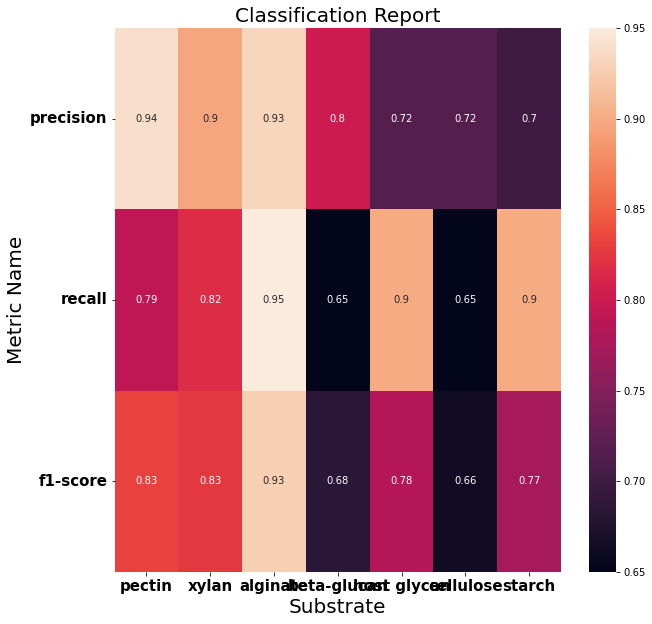

In [16]:
featurizer = "word2vec_sg"
avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(7, data, featurizer, K, known_unknown, model_sg)

In [ ]:
avg_acc

In [ ]:
fig

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

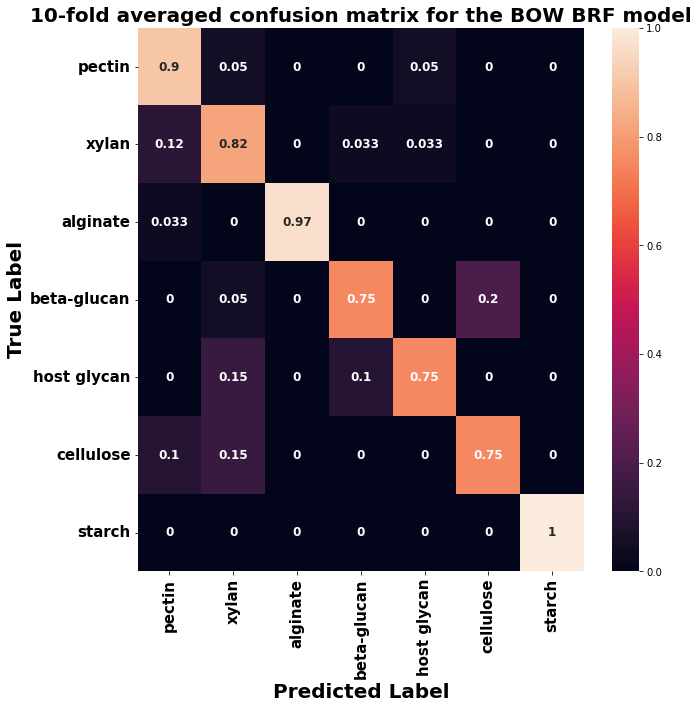

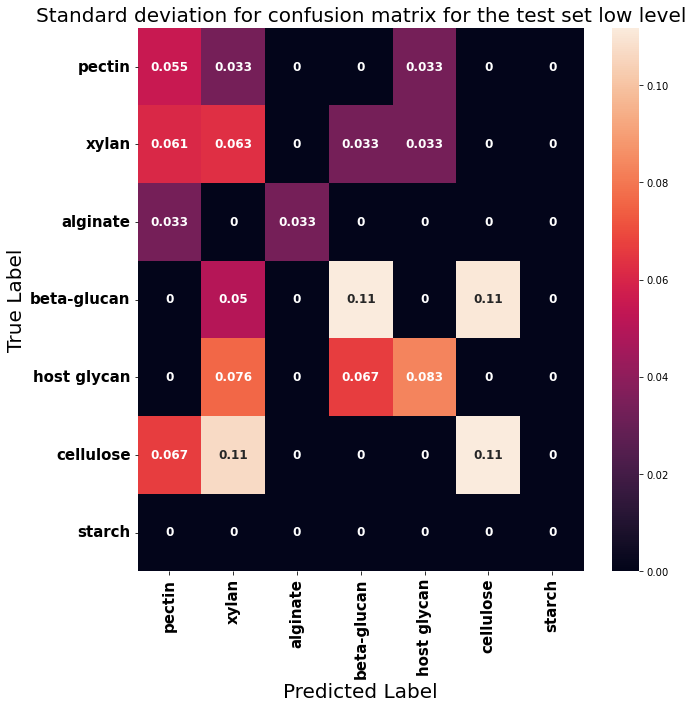

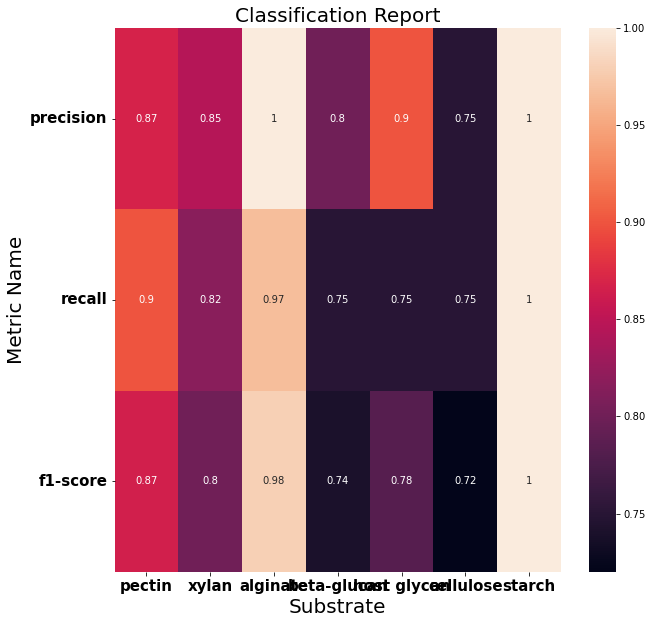

In [20]:
featurizer = "just_attention"
avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(7, data, featurizer, K, known_unknown, model_sg)

In [21]:
avg_acc

0.8511029411764707

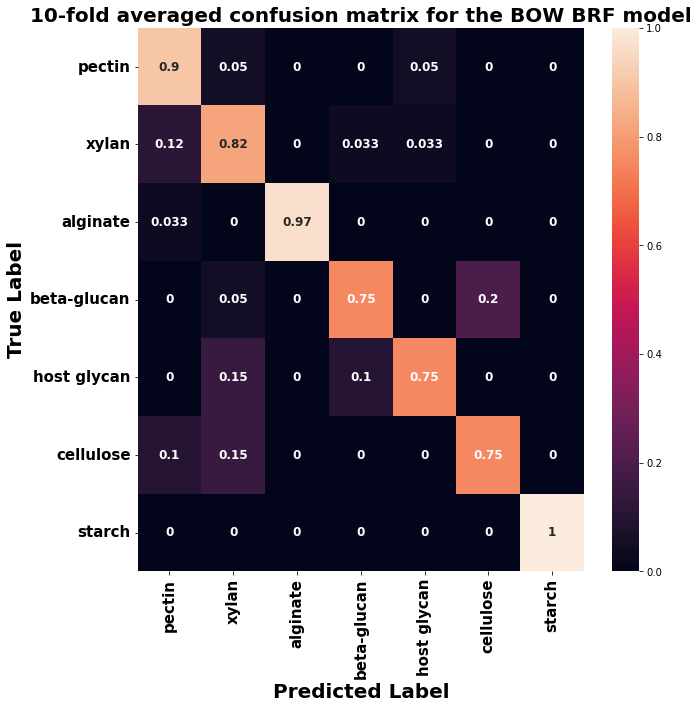

In [22]:
fig